In [1]:
import os
import javabridge
import bioformats
from bioformats import log4j
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py

ImportError: No module named h5py

In [2]:
%matplotlib inline

In [3]:
def begin_javabridge(max_heap_size='8G'):
    ''' Begin the jave virtual machine.
    Parameters
    ----------
    max_heap_size : string, optional
        Allocated memory for the virtual machine.
    Notes
    -----
    Remember to end the javabridge!
    '''

    global JVM_BEGIN

    javabridge.start_vm(class_path=bioformats.JARS,max_heap_size=max_heap_size)
    log4j.basic_config()

    JVM_BEGIN = True


In [4]:
def end_javabridge():

    ''' End the java virtual machine.
    Notes
    -----
    When killed, it cannot be restarted.
    '''

    global JVM_END

    javabridge.kill_vm()

JVM_END = True

In [5]:
JVM_BEGIN = False
JVM_END = False

def image_info(image):
    ''' Extract interesting metadata from a sincle image (not to use with batch).
    Returns
    -----
    Dict with different parameters.
    '''

    if JVM_BEGIN == False:
        begin_javabridge()
    if  JVM_END == True:
        raise RuntimeError("The java virtual Machine has already ended"
                            "you should restart the program")
    else:
        with bioformats.ImageReader(image) as rdr:
            jmd = javabridge.JWrapper(rdr.rdr.getMetadataStore())

    if jmd.getPixelsPhysicalSizeX(0) == None:
        xsize = None
    else:
        xsize = javabridge.run_script('java.lang.Double(test)',
                                      bindings_in=dict(test = jmd.getPixelsPhysicalSizeX(0)))
    if jmd.getPixelsSizeC(0) == None:
        channels = None
    else:
        channels = javabridge.run_script('java.lang.Integer(test)',
                                         bindings_in=dict(test = jmd.getPixelsSizeC(0)))
    if jmd.getPixelsSizeT(0) == None:
        time_frames = None
    else:
        time_frames = javabridge.run_script('java.lang.Integer(test)',
                                            bindings_in=dict(test = jmd.getPixelsSizeT(0)))

    if time_frames <= 1:
        time_interval = None
    else:
        t0 = javabridge.run_script('java.lang.Double(test)',
                                   bindings_in=dict(test = jmd.getPlaneDeltaT(0, 0)))
        t1 = javabridge.run_script('java.lang.Double(test)',
                                   bindings_in=dict(test = jmd.getPlaneDeltaT(0, 3)))
        time_interval = round((t1 - t0),3)

    if jmd.getPixelsSizeZ(0) == None:
        z_steps = None
    else:
        z_steps = javabridge.run_script('java.lang.Integer(test)',
                                        bindings_in=dict(test = jmd.getPixelsSizeZ(0)))
    if jmd.getPixelsPhysicalSizeZ(0) == None:
        z_step_size = None
    else:
        z_step_size = javabridge.run_script('java.lang.Double(test)',
                                            bindings_in=dict(test = jmd.getPixelsPhysicalSizeZ(0)))

    if jmd.getPixelsSizeX(0)== None:
        frame_size_x = None
    else:
        frame_size_x = javabridge.run_script('java.lang.Double(test)',
                                            bindings_in=dict(test = jmd.getPixelsSizeX(0)))

    if jmd.getPixelsSizeY(0)== None:
        frame_size_y = None
    else:
        frame_size_y = javabridge.run_script('java.lang.Double(test)',
                                            bindings_in=dict(test = jmd.getPixelsSizeY(0)))

    return {
    "xsize" : xsize,
    "channels" : channels,
    "time_frames" : time_frames,
    "time_interval": time_interval,
    "z_steps" : z_steps,
    "z_step_size" : z_step_size,
    "frame_size_x" : frame_size_x,
    "frame_size_y" : frame_size_y
    }


In [6]:
image = "second.nd2"
meta = image_info(image)

In [7]:
print(meta)

{'channels': 3, 'time_interval': 0.0, 'z_steps': 8, 'xsize': 0.325, 'z_step_size': None, 'time_frames': 97, 'frame_size_x': 2560.0, 'frame_size_y': 2160.0}


In [ ]:
with bioformats.ImageReader(image, perform_init=True) as rdr:
    t = 8
    img = np.empty([2160,2560,3,t], np.uint16)     
    for t in range(8):
        img[:,:,:,t] = rdr.read(t=t, z=6, rescale=False)

In [ ]:
print(img.shape)

In [ ]:
plt.imshow(img[:,:,1,8], cmap='gray',interpolation='nearest')

In [9]:
t = meta['time_frames']
z= meta['z_steps']
i=0

with bioformats.ImageReader(image, perform_init=True) as rdr:  
    
    img = np.empty([2160,2560,3,t], np.uint16) 
    for z in range (meta['z_steps']): 
        for t in range(meta['time_frames']):      
            img[:,:,:,t] = rdr.read(t=t, z=z, rescale=False)
        i+=1    
        np.savez("second_bis{}".format(i), header=meta, data=img)
        bioformats.clear_image_reader_cache()

In [10]:
print(img.shape)

(2160, 2560, 3, 97)


In [18]:
image =np.load("second_bis1.npz")
img = image['data'][:,:,1,:]

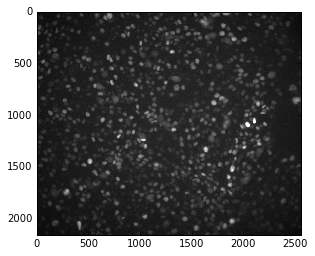

In [19]:
plt.imshow(img[:,:,96], cmap='gray',interpolation='nearest')

In [ ]:
np.savez("second", header=meta, data=img)

In [11]:
javabridge.kill_vm()

In [ ]:
image =np.load("second.npz")
img = image['data']
img_meta = image['header']

In [ ]:
def print_info(a):
    print('number of elements:', a.size)
    print('number of dimensions:', a.ndim)
    print('shape:', a.shape)
    print('data type:', a.dtype)
    print('strides:', a.strides)
    print('flags:', a.flags)

In [ ]:
print(img_meta)

In [ ]:
print(img.shape)

In [ ]:
plt.imshow(img[:,:,0,2], cmap='gray', interpolation='nearest')

In [ ]:
import psutil
print(psutil.virtual_memory())
print(psutil.swap_memory())